# Chapter 15: Diffusion Models and Text-to-Image Transformers

This chapter covers:

* How forward diffusion and reverse diffusion work
* How to build and train a denoising U-Net model
* Use the trained U-Net to generate flower images
* The idea behind text to image Transformers
* Write a Python program to generate an image through text with DALL-E 2

In recent years, multimodal large language models (LLMs) have gained significant attention for their ability to handle various content formats, such as text, images, video, audio, and code. A notable example of this is the text-to-image Transformers, such as OpenAI's DALL-E 2, Google's Imagen, and Stability AI's Stable Diffusion. These models are capable of generating high-quality images based on textual descriptions.

These text-to-image models comprise three essential components: a text encoder that compresses text into a latent representation, a method to incorporate text information into the image generation process, and a diffusion mechanism to gradually refine an image to produce realistic output. Understanding the diffusion mechanism is particularly crucial for comprehending text-to-image Transformers, as diffusion models form the foundation of all leading text-to-image Transformers. For this reason, you will start by building and training a diffusion model to generate flower images in this chapter. This will provide you with a deep understanding of the forward diffusion process, where noise is incrementally added to images until they become random noise. Subsequently, you will train a model to reverse the diffusion process by gradually removing noise from images until the model can generate a new, clean image from random noise, resembling those in the training dataset.
After that, we'll explain how a text-to-image Transformer conceptually. We'll focus on the CLIP (Contrastive Language–Image Pre-training) model developed by OpenAI, which is designed to comprehend and link visual and textual information. CLIP processes two types of inputs: images and text, typically in the form of captions or descriptions. These inputs are handled separately through two encoders in the model.

The image branch of CLIP employs a Vision Transformer (ViT) to encode images into a high-dimensional vector space, extracting visual features in the process. Meanwhile, the text branch uses a Transformer-based language model to encode textual descriptions into the same vector space, capturing semantic features from the text. CLIP's training on many pairs of matching images and text descriptions to closely align the representations of matching pairs in the vector space. OpenAI's text-to-image Transformers, such as DALL-E 2, incorporate CLIP as a core component. In this chapter, you'll learn to obtain an OpenAI API key and write a Python program to generate images using DALL-E 2 based on text descriptions.

# 1. Introduction to denoising diffusion models
# 2. Prepare the training data 
## 2.1 Flower images as the training data

In [1]:
# You need to install the following libraries first
!pip install datasets einops diffusers openai

   ---------------------------------------- 0.0/510.5 kB ? eta -:--:--
   ----------- ---------------------------- 143.4/510.5 kB 4.3 MB/s eta 0:00:01
   ---------------------------------------- 510.5/510.5 kB 6.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/346.4 kB ? eta -:--:--
   ---------------------------------------- 346.4/346.4 kB ? eta 0:00:00


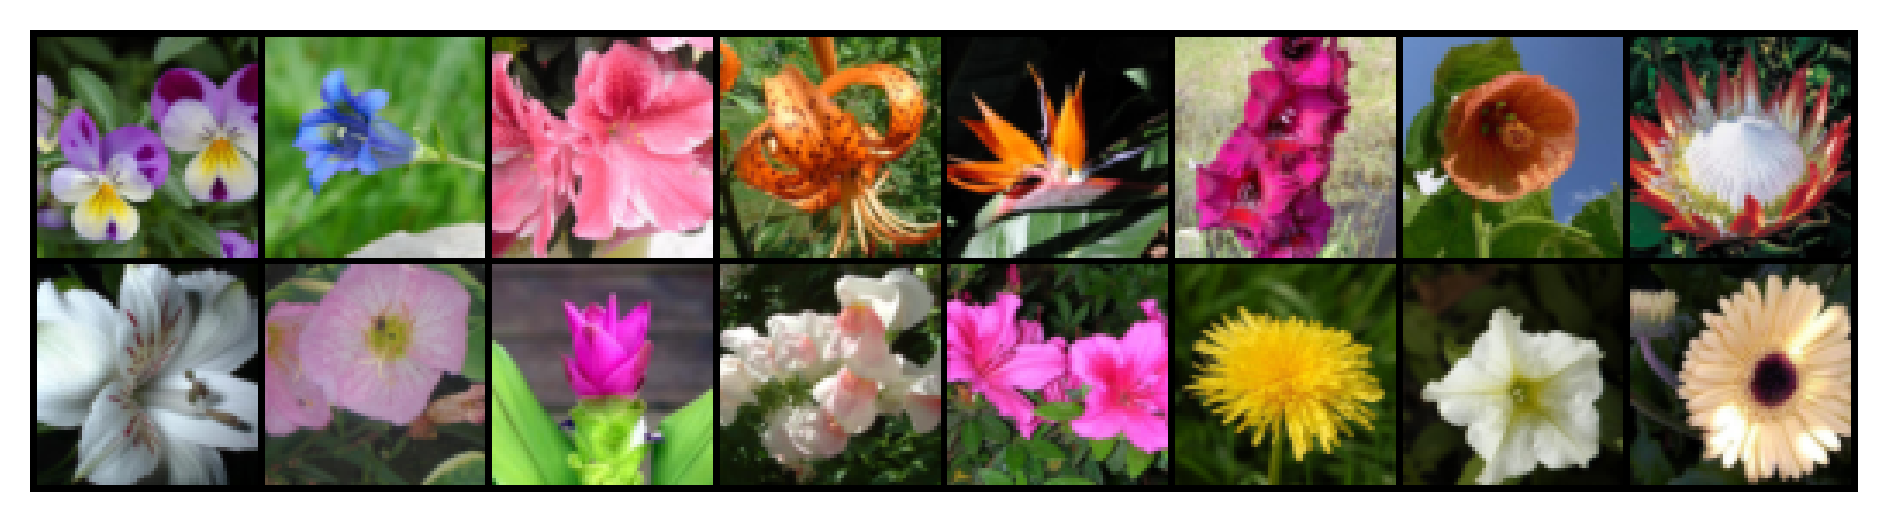

In [2]:
from datasets import load_dataset
from utils.ch15util import transforms

dataset = load_dataset("huggan/flowers-102-categories",
    split="train",)
dataset.set_transform(transforms)

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Plot all the images of the 1st batch in grid
grid = make_grid(dataset[:16]["input"], 8, 2)
plt.figure(figsize=(8,2),dpi=300)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis("off")
plt.show()

In [3]:
import torch

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
resolution=64
batch_size=4
train_dataloader=torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True)

## 2.2	Visualize the forward diffusion process

In [4]:
clean_images=next(iter(train_dataloader))["input"]*2-1
print(clean_images.shape)
nums=clean_images.shape[0]
noise=torch.randn(clean_images.shape)
print(noise.shape)

torch.Size([4, 3, 64, 64])
torch.Size([4, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


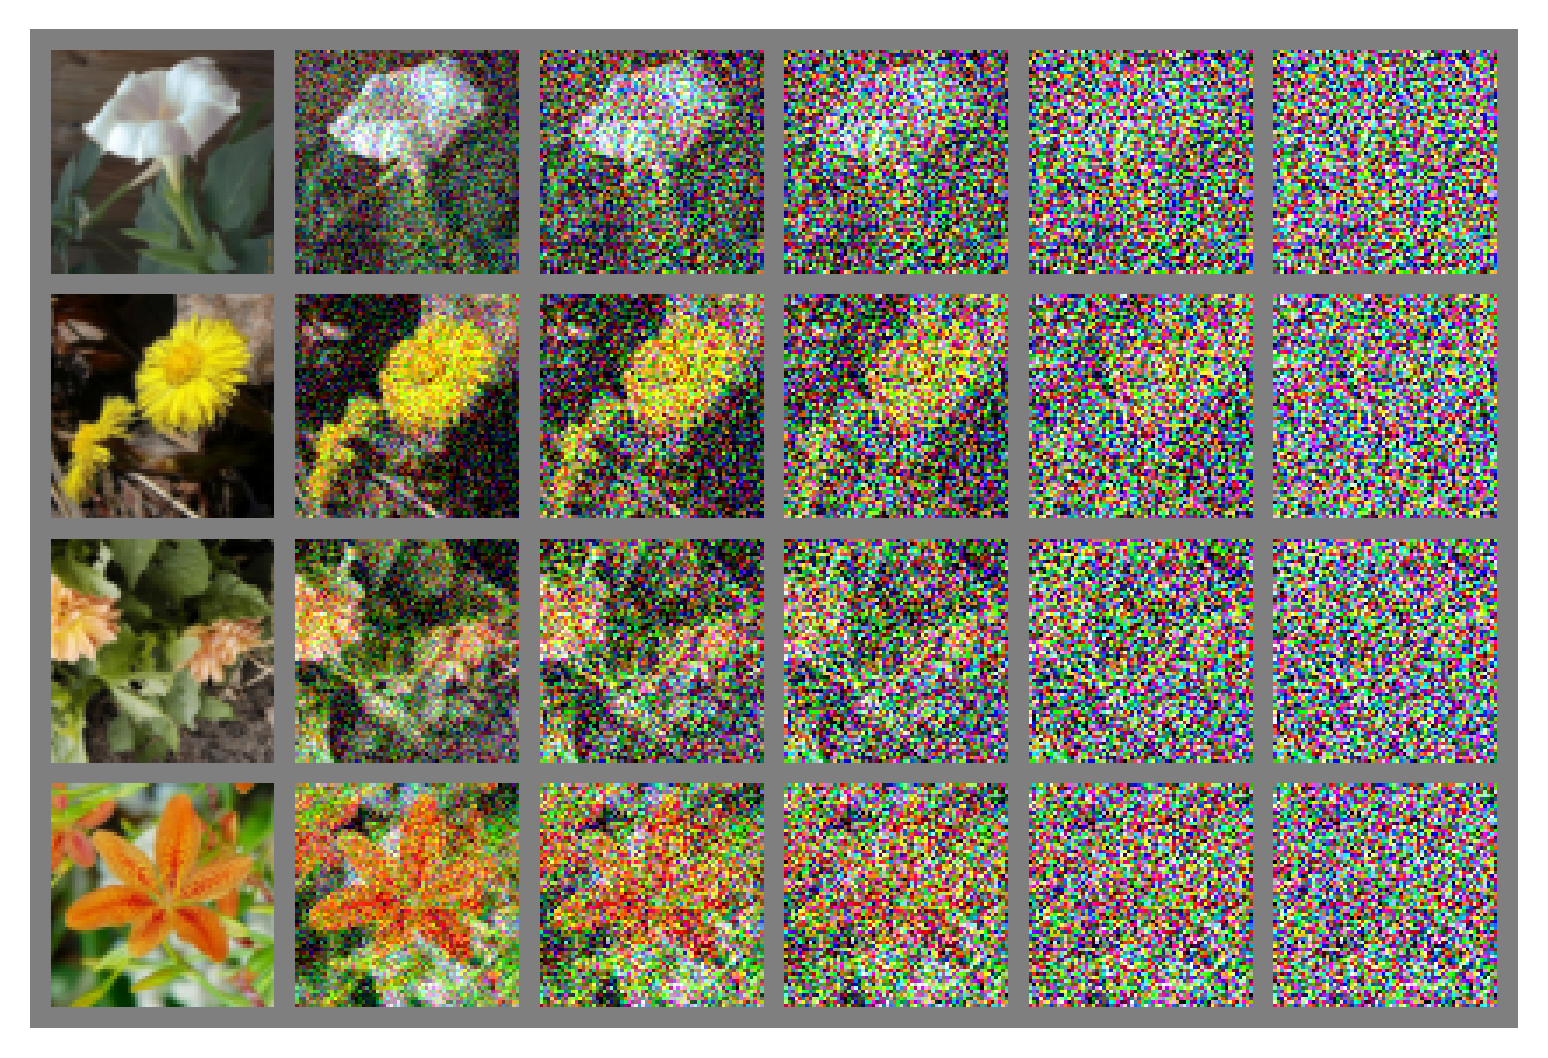

In [5]:
from utils.ch15util import DDIMScheduler

noise_scheduler=DDIMScheduler(num_train_timesteps=1000)
allimgs=clean_images
for step in range(200,1001,200):
    timesteps=torch.tensor([step-1]*4).long()
    noisy_images=noise_scheduler.add_noise(clean_images,
                 noise, timesteps)
    allimgs=torch.cat((allimgs,noisy_images))

import torchvision
imgs=torchvision.utils.make_grid(allimgs,4,6)
fig = plt.figure(dpi=300)
plt.imshow((imgs.permute(2,1,0)+1)/2)
plt.axis("off")
plt.show()

# 3	Build a denoising U-Net model
## 3.1	The attention mechanism in the denoising U-Net model 

In [6]:
# the Attention() class is defined in ch15util.py
import torch
from torch import nn, einsum
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)
    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)    #A
        q, k, v = map(
        lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads),
        qkv)    #B
        q = q * self.scale    
        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim=-1)    #C
        out = einsum('b h i j, b h d j -> b h i d', attn, v)    #D
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return self.to_out(out)    #E
attn=Attention(128)
x=torch.rand(1,128,64,64)
out=attn(x)
print(out.shape)

torch.Size([1, 128, 64, 64])


## 3.2	The denoising U-Net model

In [7]:
from utils.unet_util import UNet

device="cuda" if torch.cuda.is_available() else "cpu"
resolution=64
model=UNet(3,hidden_dims=[128,256,512,1024],
           image_size=resolution).to(device)
num=sum(p.numel() for p in model.parameters())
print("number of parameters: %.2fM" % (num/1e6,))
print(model)

number of parameters: 133.42M
UNet(
  (time_embedding): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (init_conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResidualBlock(
        (time_emb_proj): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (residual_conv): Identity()
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlinearity): SiLU()
      )
      (2): Identity()
      (3): Sequential(
        (0): Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
     

# 4	Train and use the denoising U-Net model
## 4.1 Train the denoising U-Net model

In [8]:
from diffusers.optimization import get_scheduler

num_epochs=100
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0001,
    betas=(0.95,0.999),weight_decay=0.00001,eps=1e-8)
lr_scheduler=get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=300,
    num_training_steps=(len(train_dataloader) * num_epochs))

In [9]:
for epoch in range(num_epochs):
    model.train()
    tloss = 0
    print(f"start epoch {epoch}")
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["input"].to(device)*2-1
        nums = clean_images.shape[0]
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(0,
                noise_scheduler.num_train_timesteps,
                (nums, ),
                device=device).long()
        noisy_images = noise_scheduler.add_noise(clean_images,
                     noise, timesteps)

        noise_pred = model(noisy_images, timesteps)["sample"]
        loss = torch.nn.functional.l1_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        tloss += loss.detach().item()
        if step%100==0:
            print(f"step {step}, average loss {tloss/(step+1)}")

torch.save(model.state_dict(),'files/diffusion.pth')

## 4.2 Use the trained model to generate flower images

```python
# this is defined in the DDIMScheduler() class in ch15util.py
    @torch.no_grad()
    def generate(self,model,device,batch_size=1,generator=None,
         eta=1.0,use_clipped_model_output=True,num_inference_steps=50):
        imgs=[]
        image=torch.randn((batch_size,model.in_channels,model.sample_size,
            model.sample_size),generator=generator).to(device)
        self.set_timesteps(num_inference_steps)
        for t in tqdm(self.timesteps):
            model_output = model(image, t)["sample"]
            image = self.step(model_output,t,image,eta,
                  use_clipped_model_output=use_clipped_model_output)
            img = unnormalize_to_zero_to_one(image)
            img = img.cpu().permute(0, 2, 3, 1).numpy()
            imgs.append(img)
        image = unnormalize_to_zero_to_one(image)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        return {"sample": image}, imgs
```

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


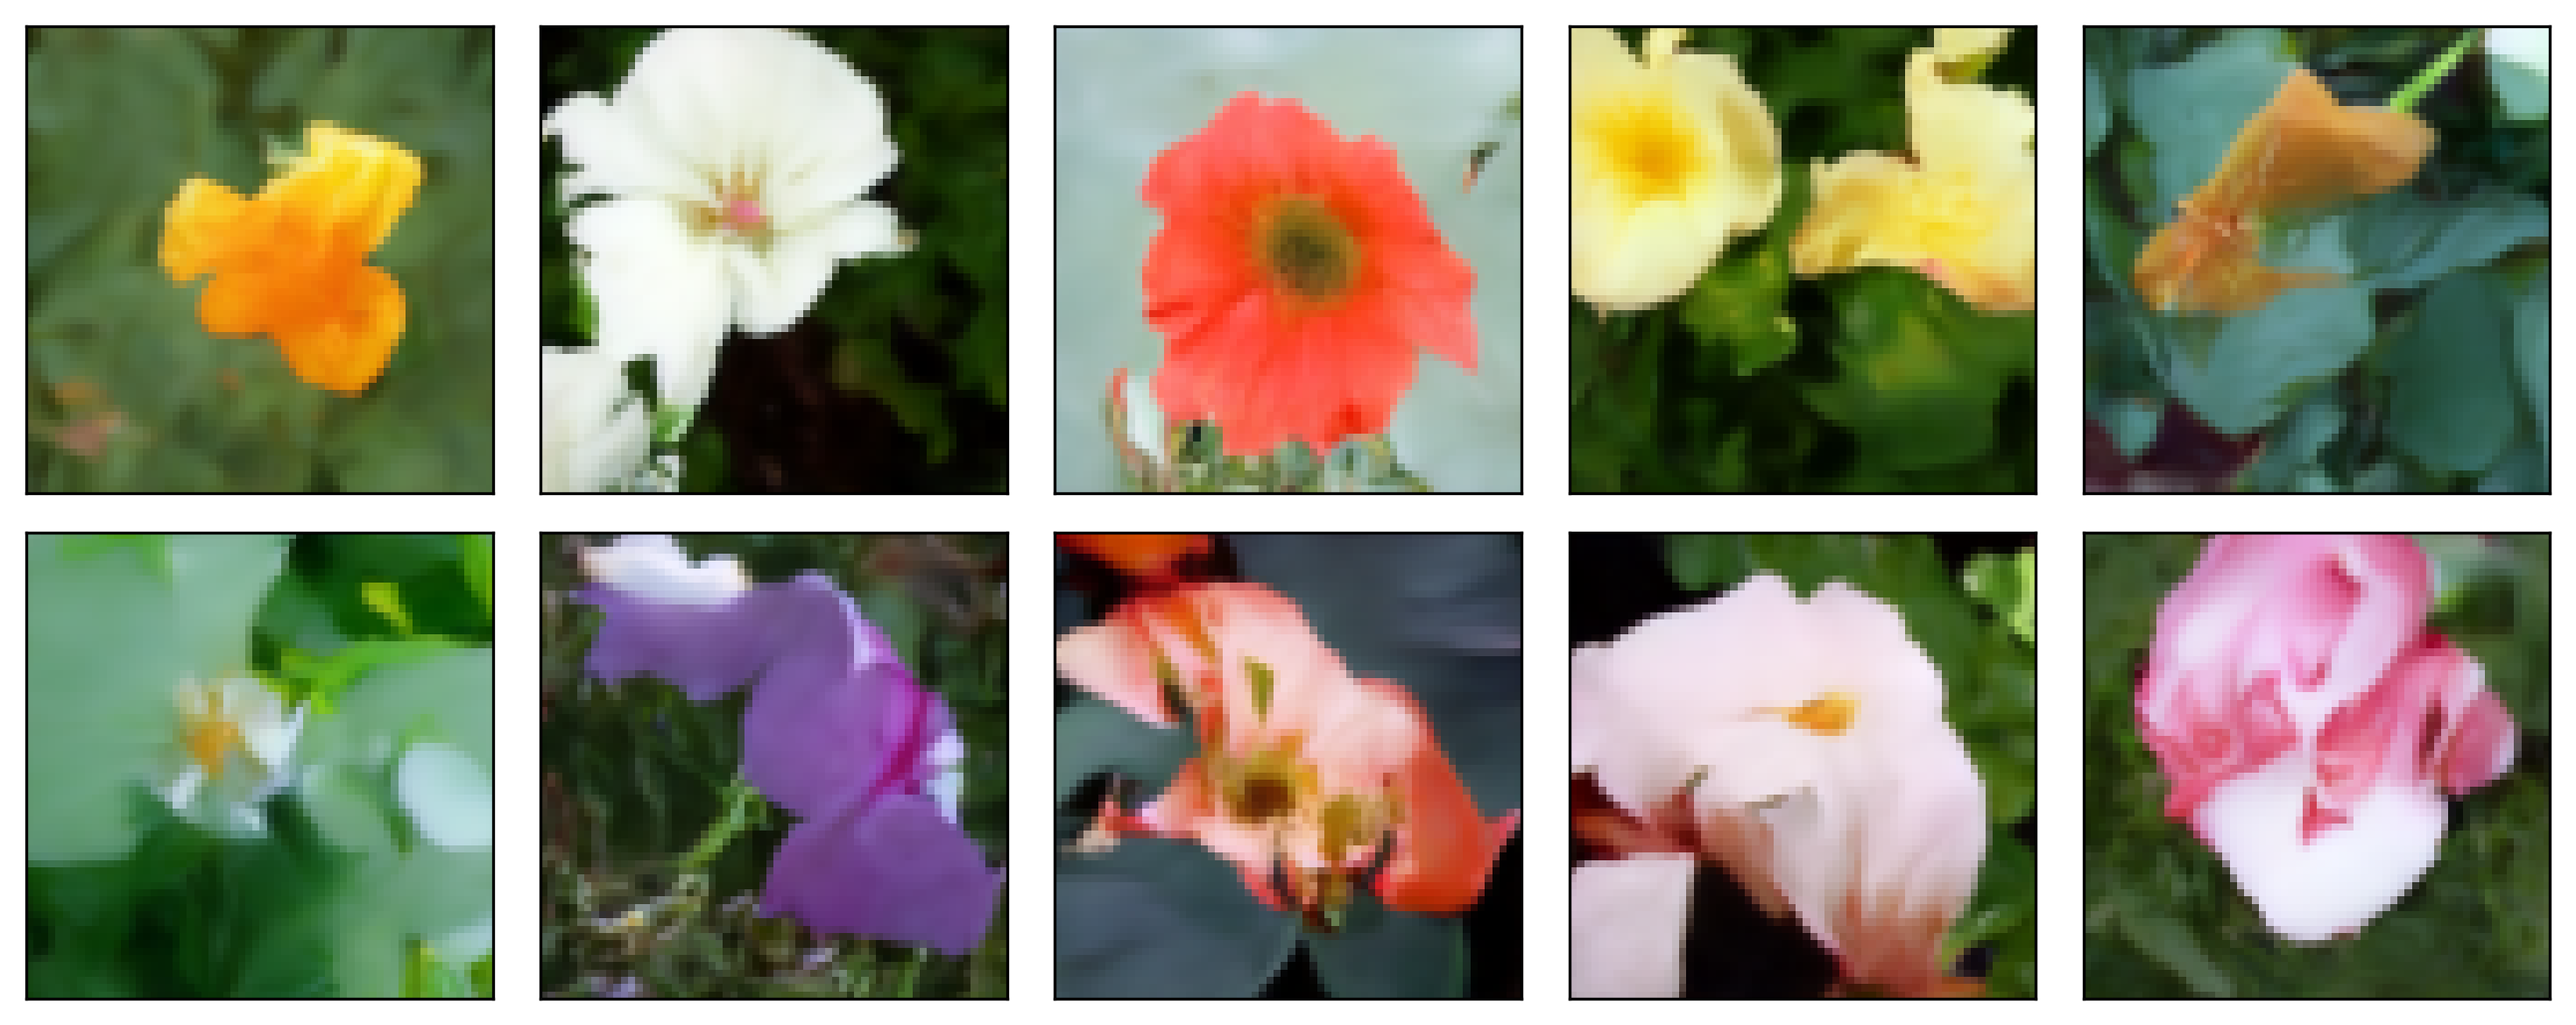

In [10]:
sd=torch.load('files/diffusion.pth')
model.load_state_dict(sd)
with torch.no_grad():
    generator = torch.manual_seed(1)
    generated_images,imgs = noise_scheduler.generate(
        model,device,
        num_inference_steps=50,
        generator=generator,
        eta=1.0,
        use_clipped_model_output=True,
        batch_size=10)
imgnp=generated_images["sample"]    
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4),dpi=300)
for i in range(10):
    ax = plt.subplot(2,5, i + 1)
    plt.imshow(imgnp[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [11]:
# exercise 15.1
with torch.no_grad():
    generator = torch.manual_seed(2)
    generated_images,_ = noise_scheduler.generate(
        model,device,
        num_inference_steps=50,
        generator=generator,
        eta=1.0,
        use_clipped_model_output=True,
        batch_size=10)
imgnp=generated_images["sample"]    
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4),dpi=300)
for i in range(10):
    ax = plt.subplot(2,5, i + 1)
    plt.imshow(imgnp[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

<img src="https://gattonweb.uky.edu/faculty/lium/gai/seed2.png" />

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

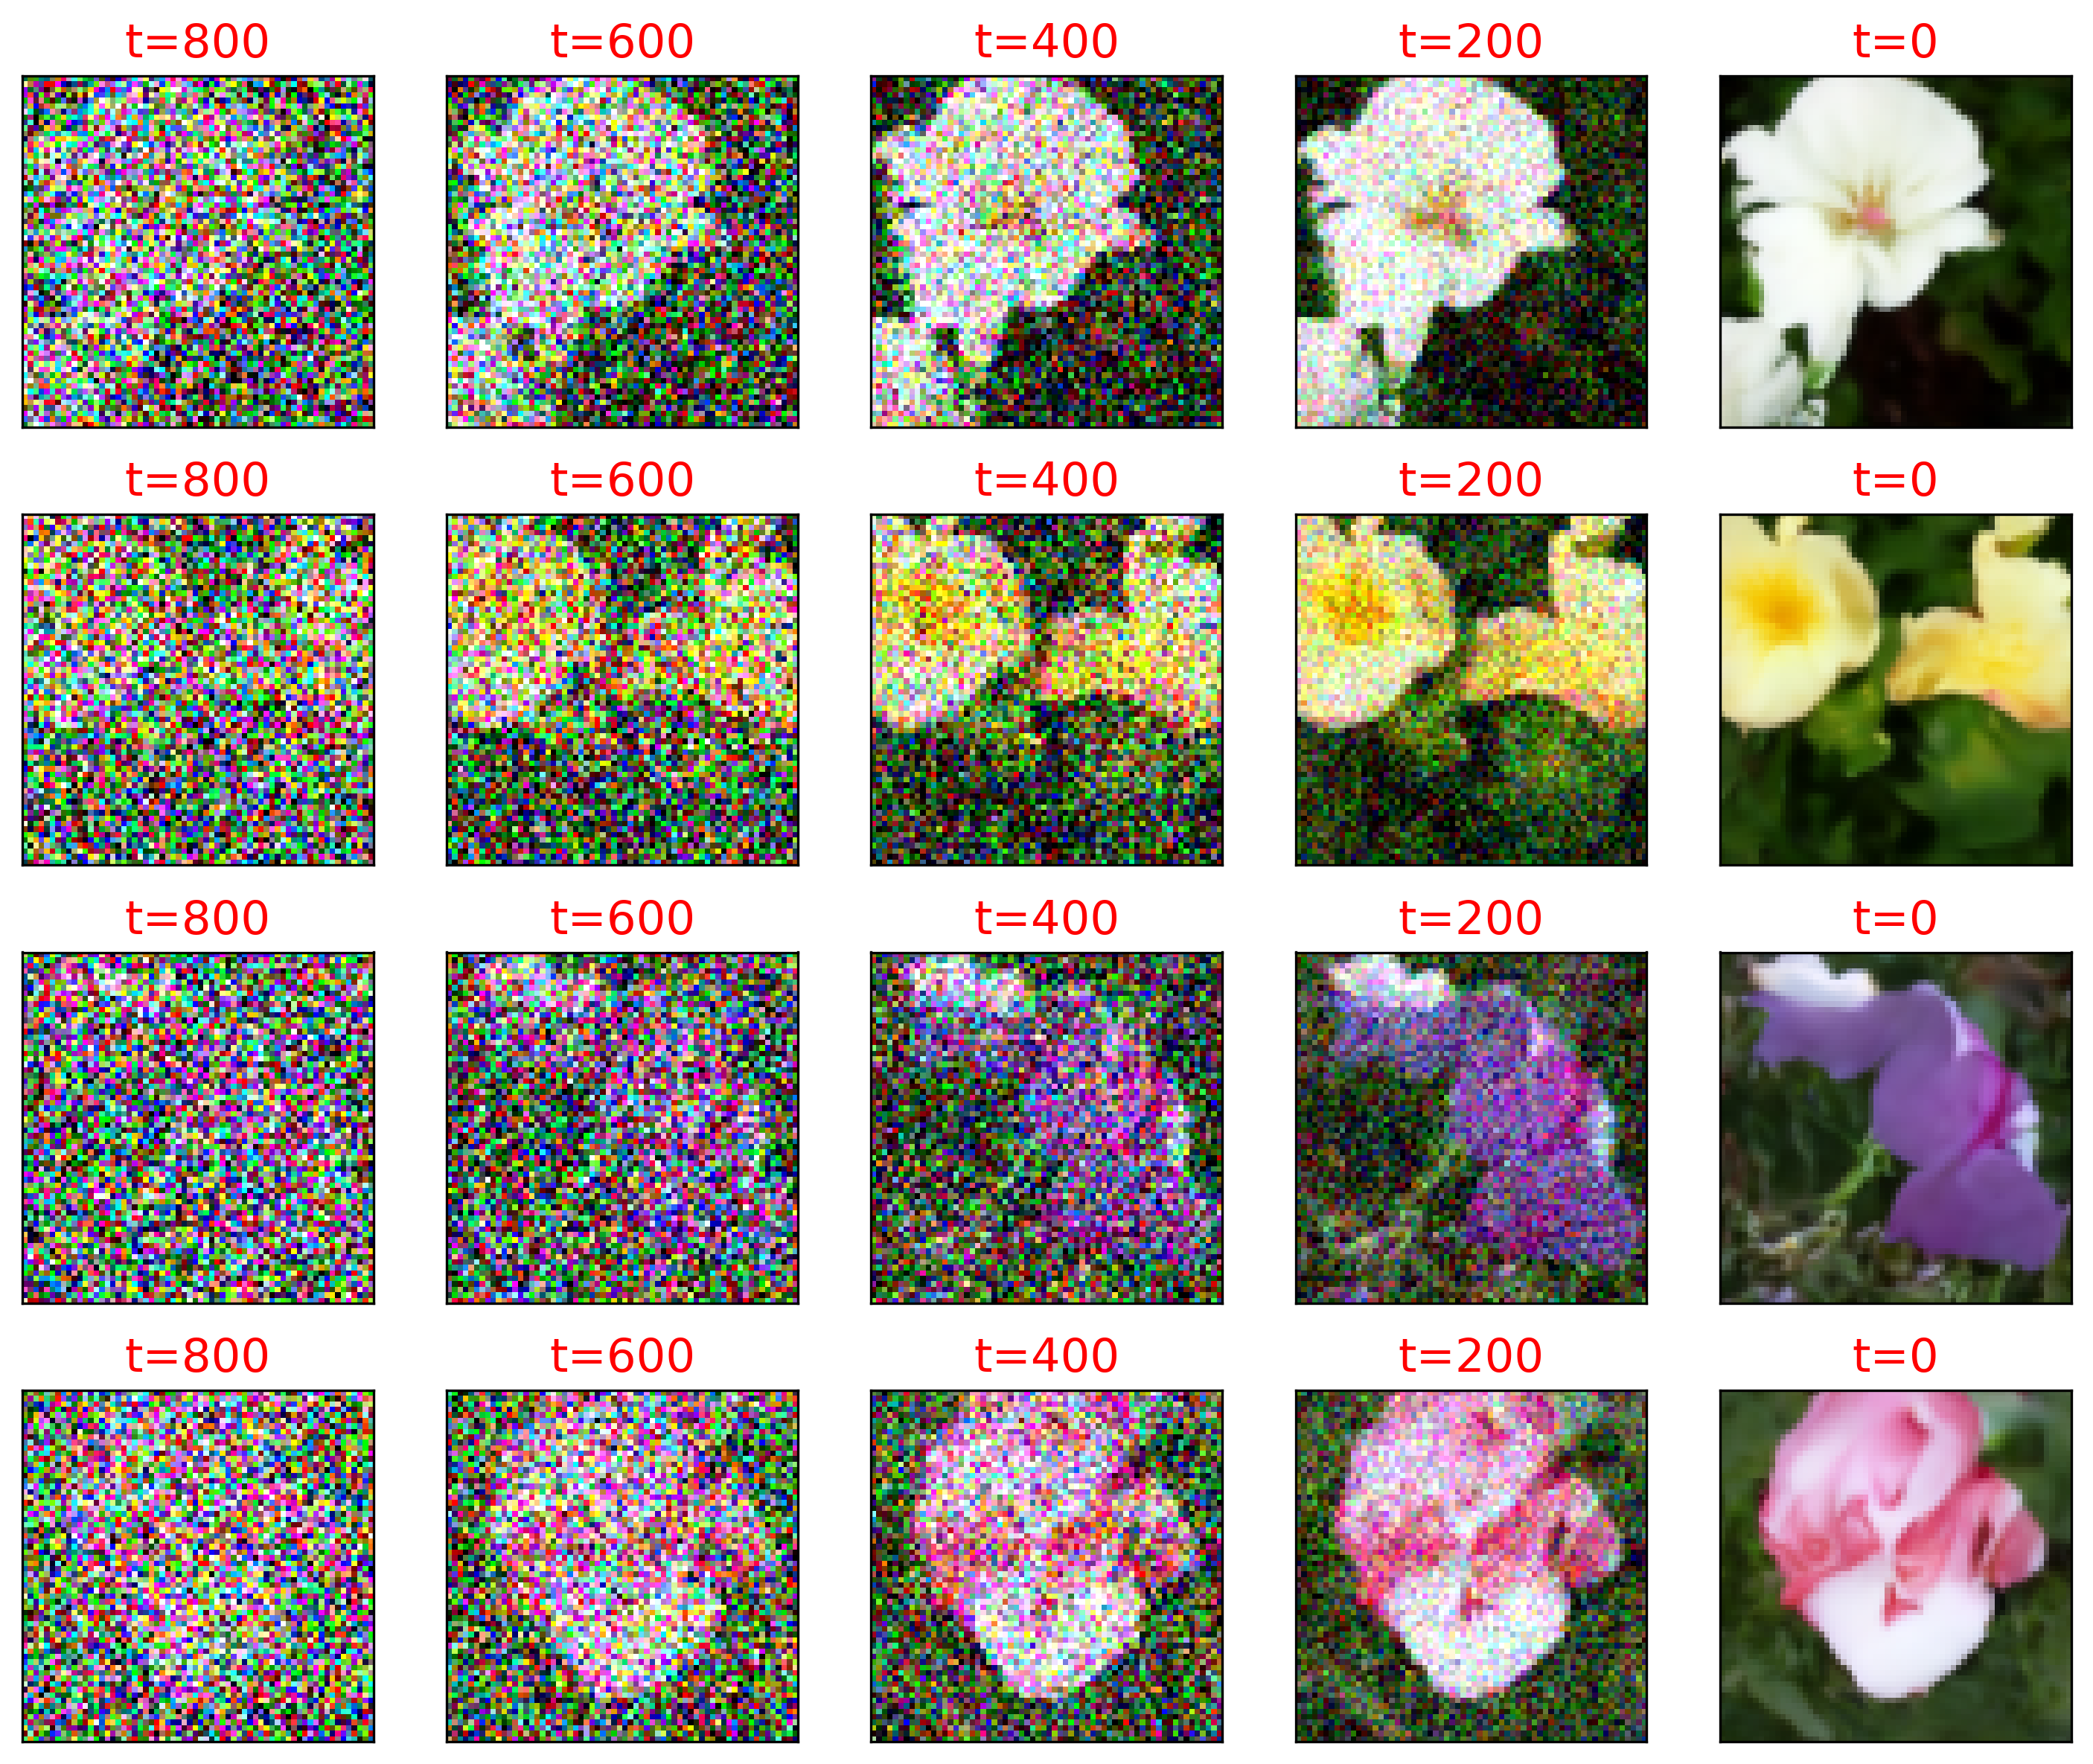

In [12]:
# keep time steps 800, 600, 400, 200, and 0
steps=imgs[9::10]
# select four sets of flowers out of ten
imgs20=[]
for j in [1,3,6,9]:
    for i in range(5):
        imgs20.append(steps[i][j])
# plot the 20 images in a 4 by 5 grid
plt.figure(figsize=(10,8),dpi=300)
for i in range(20):
    k=i%5
    ax = plt.subplot(4,5, i + 1)
    plt.imshow(imgs20[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f't={800-200*k}',fontsize=15,c="r")
plt.show()

In [13]:
# https://platform.openai.com/docs/models for a list of models
from openai import OpenAI

openai_api_key=your actual OpenAI API key here, in quotes
client=OpenAI(api_key=openai_api_key)

# generte image
response = client.images.generate(
  model="dall-e-2",
  prompt="an astronaut in a space suit riding a unicorn",
  size="512x512",
  quality="standard",
  n=1,
)
image_url = response.data[0].url
print(image_url)

<img src="https://gattonweb.uky.edu/faculty/lium/gai/unicorn.png" />

In [14]:
# exercise 15.2
response = client.images.generate(
  model="dall-e-2",
  prompt="a cat in a suit working on a computer",
  size="512x512",
  quality="standard",
  n=1,
)    
image_url = response.data[0].url
print(image_url)

<img src="https://gattonweb.uky.edu/faculty/lium/gai/catsuit.png" />